# 54 Converting PyVista Mesh to ZMAP Grid

After creating a model, the resulting surfaces are often needed for further processing or visualization. One common grid type are ZMAP Grids (https://gdal.org/drivers/raster/zmap.html) common to the O&G industry and readable in GIS packages like ArcGIS or QGIS. In this notebook, we present methods to convert a PyVista mesh, the resulting surface when using GemPy for structural geological modeling to a ZMAP grid.

<img src="../images/tutorial54_cover.png">


## Set File Paths and download Tutorial Data

If you downloaded the latest `GemGIS` version from the Github repository, append the path so that the package can be imported successfully. Otherwise, it is recommended to install `GemGIS` via `pip install gemgis` and import `GemGIS` using `import gemgis as gg`. In addition, the file path to the folder where the data is being stored is set. The tutorial data is downloaded using Pooch (https://www.fatiando.org/pooch/latest/index.html) and stored in the specified folder. Use `pip install pooch` if Pooch is not installed on your system yet.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import gemgis as gg
import geopandas as gpd
import rasterio
import gempy as gp
import pyvista as pv
import matplotlib.pyplot as plt
import numpy as np

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
file_path ='data/54_converting_pyvista_mesh_to_zmap_grid/'
gg.download_gemgis_data.download_tutorial_data(filename="54_converting_pyvista_mesh_to_zmap_grid.zip", dirpath=file_path)

## Creating GemPy Model

### Loading Topography

In [3]:
topo_raster = rasterio.open(file_path + 'raster1.tif')

### Creating Interfaces

In [4]:
interfaces = gpd.read_file(file_path + 'interfaces1_lines.shp')
interfaces_coords = gg.vector.extract_xyz(gdf=interfaces, dem=topo_raster)
interfaces_coords.head()

,formation,geometry,X,Y,Z
0,Sand1,POINT (0.256 264.862),0.26,264.86,353.97
1,Sand1,POINT (10.593 276.734),10.59,276.73,359.04
2,Sand1,POINT (17.135 289.090),17.13,289.09,364.28
3,Sand1,POINT (19.150 293.313),19.15,293.31,364.99
4,Sand1,POINT (27.795 310.572),27.80,310.57,372.81


### Creating Orientations

In [5]:
orientations = gpd.read_file(file_path + 'orientations1.shp')
orientations = gg.vector.extract_xyz(gdf=orientations, dem=topo_raster)
orientations['polarity'] = 1
orientations

,formation,dip,azimuth,geometry,X,Y,Z,polarity
0,Ton,30.50,180.00,POINT (96.471 451.564),96.47,451.56,440.59,1
1,Ton,30.50,180.00,POINT (172.761 661.877),172.76,661.88,556.38,1
2,Ton,30.50,180.00,POINT (383.074 957.758),383.07,957.76,729.02,1
3,Ton,30.50,180.00,POINT (592.356 722.702),592.36,722.70,601.55,1
4,Ton,30.50,180.00,POINT (766.586 348.469),766.59,348.47,378.63,1
5,Ton,30.50,180.00,POINT (843.907 167.023),843.91,167.02,282.61,1
6,Ton,30.50,180.00,POINT (941.846 428.883),941.85,428.88,423.45,1
7,Ton,30.50,180.00,POINT (22.142 299.553),22.14,299.55,368.05,1


### Calculating GemPy Model

In [6]:
geo_model = gp.create_model('Model1')
gp.init_data(geo_model, [0, 972, 0, 1069, 300, 800], [50, 50, 50],
             surface_points_df=interfaces_coords,
             orientations_df=orientations,
             default_values=True)
gp.map_stack_to_surfaces(geo_model,
                         {'Strata': ('Sand1', 'Ton')},
                         remove_unused_series=True)
geo_model.add_surfaces('Basement')
geo_model.set_topography(source='gdal', filepath=file_path + 'raster1.tif')
gp.set_interpolator(geo_model,
                    compile_theano=True,
                    theano_optimizer='fast_compile',
                    verbose=[],
                    update_kriging=False
                    )
sol = gp.compute_model(geo_model, compute_mesh=True)

Active grids: ['regular']
Cropped raster to geo_model.grid.extent.
depending on the size of the raster, this can take a while...
storing converted file...
Active grids: ['regular' 'topography']
Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                   values
range             1528.9
$C_o$           55655.83
drift equations      [3]


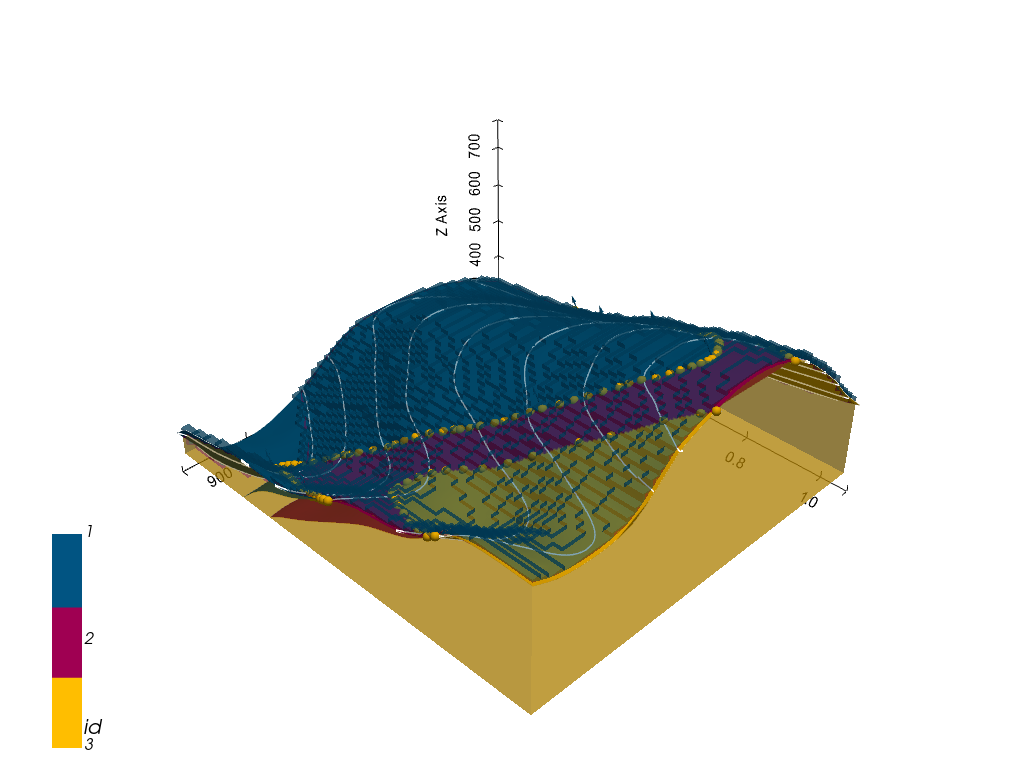

In [7]:
gpv = gp.plot_3d(geo_model, 
                 image=False, 
                 show_topography=True,
                 plotter_type='basic', 
                 notebook=True, 
                 show_lith=True,
                 show_boundaries=True)

## Extracting Surfaces from the GemPy Model

In [8]:
mesh = gg.visualization.create_depth_maps_from_gempy(geo_model=geo_model, surfaces=['Sand1', 'Ton'])
mesh

{'Sand1': [PolyData (0x28273f07b20)
    N Cells:	4209
    N Points:	2325
    X Bounds:	9.720e+00, 9.623e+02
    Y Bounds:	1.672e+02, 9.497e+02
    Z Bounds:	3.050e+02, 7.250e+02
    N Arrays:	1,
  '#015482'],
 'Ton': [PolyData (0x28273f079a0)
    N Cells:	5396
    N Points:	2891
    X Bounds:	9.720e+00, 9.623e+02
    Y Bounds:	2.799e+02, 1.058e+03
    Z Bounds:	3.050e+02, 7.297e+02
    N Arrays:	1,
  '#9f0052']}

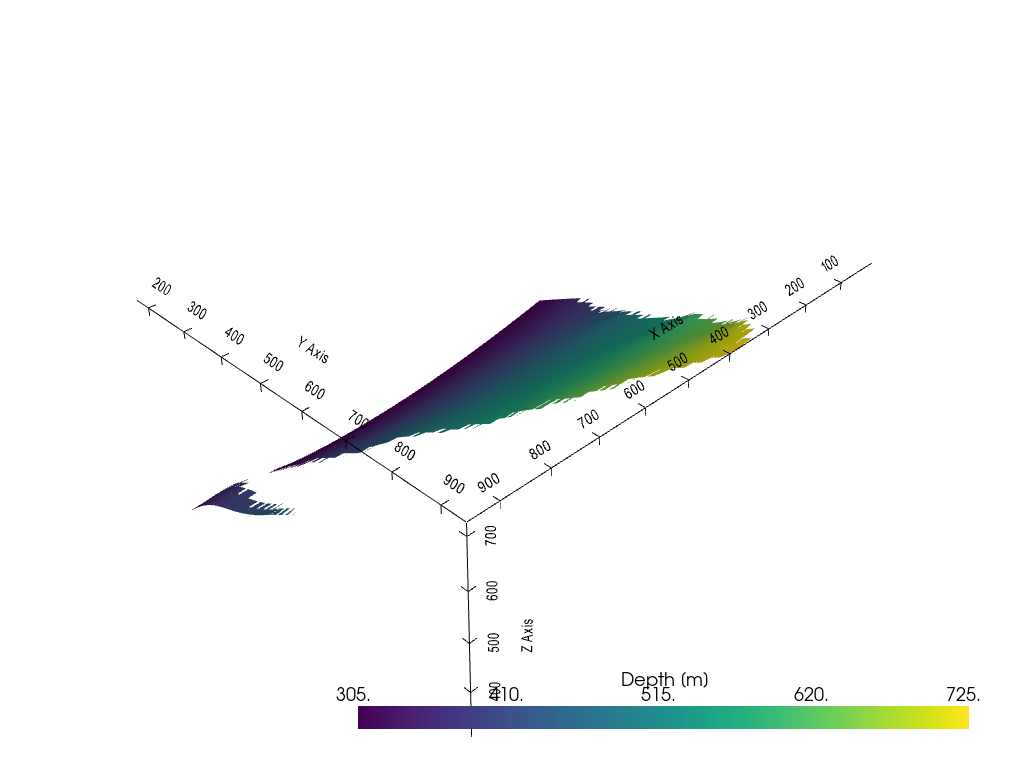

In [9]:
p = pv.Plotter(notebook=True)

p.add_mesh(mesh['Sand1'][0], scalars = 'Depth [m]')
p.show_bounds()
p.show()

## Creating the ZMAP Grid

In [10]:
from typing import Union
def ray_trace_one_surface(surface: pv.core.pointset.PolyData,
                          origin: Union[np.ndarray, list],
                          end_point: Union[np.ndarray, list],
                          first_point: bool = False) -> tuple:
    """Function to return the depth of one surface in one well using PyVista ray tracing

    Parameters:
    ___________

        surface: pv.core.pointset.PolyData
            Calculated GemPy surface

        origin:
            Coordinates of the top of the well

        end_point:
            Coordinates of the bottom of the well

        first_point: bool
            Returns intersection of first point only

    """

    intersection_points, intersection_cells = surface.ray_trace(origin=origin,
                                                                end_point=end_point,
                                                                first_point=first_point)

    return intersection_points, intersection_cells

def extract_zmap_data(surface: pv.core.pointset.PolyData,
                      cell_width: int,
                      nodata: Union[float, int] = -9999):
    """

    """

    # Extracting extent
    extent = surface.bounds

    # Calculating x dimension
    x_dim = extent[1] - extent[0]
    

    # Calculating y dimension
    y_dim = extent[3] - extent[2]

    # Calculate number of cells in x direction
    x_no_cells = round(x_dim / cell_width)

    # Calculate number of cells in y direction
    y_no_cells = round(y_dim / cell_width)

    # Calculate coordinates in x direction
    x = np.arange(extent[0] + 0.5 * cell_width, extent[1], cell_width)

    # Calculate coordinates in y direction
    y = np.arange(extent[2] + 0.5 * cell_width, extent[3], cell_width)

    intersections = [ray_trace_one_surface(surface=surface,
                                           origin=[x_value, y_value, extent[4]],
                                           end_point=[x_value, y_value, extent[5]],
                                           first_point=True) for x_value in x for y_value in y]

    z_values = np.fliplr(np.array([z[0][2] if len(z[0])==3 else nodata for z in intersections]).reshape(x_no_cells, y_no_cells))

    
    
    return z_values

def create_zmap_grid(surface: pv.core.pointset.PolyData,
                     cell_width: int,
                     comments: str = '',
                     name: str = 'ZMAP_GRID',
                     z_type: str = 'GRID',
                     nodes_per_line: int = 5,
                     field_width: int = 15,
                     nodata: Union[int, float] = -9999.00000,
                     nodata2: Union[int, float, str] = '',
                     decimal_places: int = 5,
                     start_column: int = 1):
    """Function to write data to ZMAP Grid

    Parameters:
    ___________
    
        surface: pv.core.pointset.PolyData
            PyVista mesh

        cell_width: int
            Width of grid cell
            
        comments: str
            Comments written to the ZMAP File
            
        name: str
            Name of the ZMAP File
            
        z_type: str
            ZMAP Grid Type
            
        nodes_per_lines: int
            Number of values per line
        
        field_width: int
            Width of each field
            
        nodata: Union[int, float]
            No data value
        
        nodata2:  Union[int, float, str]
            No data value
            
        decimal_places: int
            Number of Decimal Places
        
        start_column: int
            Number of the start column
    """

    # Extracting z_values
    z_values = extract_zmap_data(surface=surface,
                                 cell_width=cell_width,
                                 nodata=nodata)
    
    #Defining extent
    extent = surface.bounds

    # Defining the number of rows and columns
    no_cols = z_values.shape[0]
    no_rows = z_values.shape[1]

    # Defining auxilliary function
    def chunks(x, n):
        for i in range(0, len(x), n):
            yield x[i: i + n]

    lines = []

    lines.append('!')
    lines.append('! This ZMAP Grid was created using the GemGIS Package')
    lines.append('! See https://github.com/cgre-aachen/gemgis for more information')
    lines.append('!')

    for comment in comments:
        lines.append('! ' + comment)

    lines.append('!')

    lines.append("@{}, {}, {}".format(name, z_type, nodes_per_line))

    lines.append(
        "{}, {}, {}, {}, {}".format(
            field_width,
            nodata,
            nodata2,
            decimal_places,
            start_column,
        )
    )

    lines.append(
        "{}, {}, {}, {}, {}, {}".format(
            no_rows,
            no_cols,
            extent[0],
            extent[1],
            extent[2],
            extent[3]
        )
    )

    lines.append("0.0, 0.0, 0.0")
    lines.append("@")

    for i in z_values:
        for j in chunks(i, nodes_per_line):
            j_fmt = "0.{}f".format(decimal_places)
            j_fmt = "{0:" + j_fmt + "}"
            j = [j_fmt.format(float(x)) if not x is np.nan else j_fmt.format(float(nodata)) for x in j]
            line = "{:>" + "{}".format(field_width) + "}"
            lines.append("".join([line] * len(j)).format(*tuple(j)))

    return lines

def save_zmap_grid(zmap_grid: list,
                   path: str = 'ZMAP_Grid.dat'):
    """Function to save ZMAP Grid information to file

    Parameters:
    ___________
    
        zmap_grid: list
            List of strings containing the ZMAP Data
            
        path: str
            Path and filename to store the ZMAP Grid

    """

    # Writing the ZMAP Grid to file
    with open(path, 'w') as f:
        f.write("\n".join(zmap_grid))

    print('ZMAP Grid successfully saved to file')

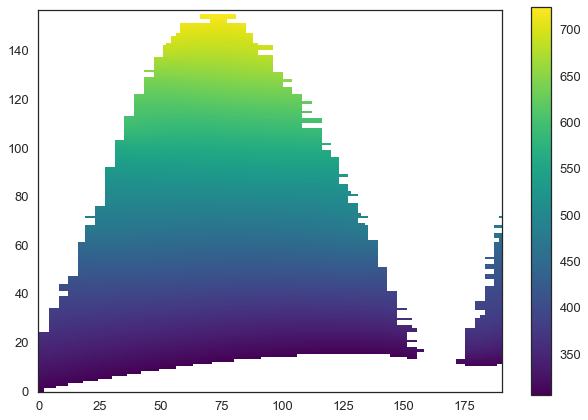

In [11]:
z_values = extract_zmap_data(surface=mesh['Sand1'][0], 
                            cell_width=5)

z_values[z_values == -9999] = np.nan
im = plt.imshow(np.flipud(z_values.T), cmap='viridis')
plt.gca().invert_yaxis()
plt.colorbar(im)

In [12]:
zmap_grid = create_zmap_grid(surface=mesh['Sand1'][0],
                     cell_width=5, comments=['Hi'], nodata=-9999
                     )
zmap_grid

['!',
 '! This ZMAP Grid was created using the GemGIS Package',
 '! See https://github.com/cgre-aachen/gemgis for more information',
 '!',
 '! Hi',
 '!',
 '@ZMAP_GRID, GRID, 5',
 '15, -9999, , 5, 1',
 '157, 191, 9.72, 962.2800000000001, 167.18766848564147, 949.705025253296',
 '0.0, 0.0, 0.0',
 '@',
 '    -9999.00000    -9999.00000    -9999.00000    -9999.00000    -9999.00000',
 '    -9999.00000    -9999.00000    -9999.00000    -9999.00000    -9999.00000',
 '    -9999.00000    -9999.00000    -9999.00000    -9999.00000    -9999.00000',
 '    -9999.00000    -9999.00000    -9999.00000    -9999.00000    -9999.00000',
 '    -9999.00000    -9999.00000    -9999.00000    -9999.00000    -9999.00000',
 '    -9999.00000    -9999.00000    -9999.00000    -9999.00000    -9999.00000',
 '    -9999.00000    -9999.00000    -9999.00000    -9999.00000    -9999.00000',
 '    -9999.00000    -9999.00000    -9999.00000    -9999.00000    -9999.00000',
 '    -9999.00000    -9999.00000    -9999.00000    -9999.000

In [13]:
save_zmap_grid(zmap_grid, path='ZMAP_Grid.dat')

ZMAP Grid successfully saved to file
